In [88]:
import pandas as pd
import numpy as np
import import_ipynb
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr, spearmanr
from fastdtw import fastdtw
import random
from Barycenter_DTW import resample_sequence, barycenter_dtw
from Weighted_DTW import weighted_dtw

# random.seed(42)

In [89]:
# Use %store to retrieve the variable
%store -r z_jump_rs
%store -r z_walk_rs
%store -r z_skip_rs
%store -r z_skip
%store -r z_skip_cycles

# candidate 2
%store -r g_jump_rs
%store -r g_walk_rs
%store -r g_skip_rs
%store -r g_skip
%store -r g_skip_cycles

## Shapelet results

In [90]:
# barycenter_dtw
z_barycenter_df = barycenter_dtw(pd.DataFrame(z_walk_rs), pd.concat([pd.DataFrame(z_jump_rs), pd.DataFrame(z_jump_rs)], ignore_index=True))

g_barycenter_df = barycenter_dtw(pd.DataFrame(g_walk_rs), pd.concat([pd.DataFrame(g_jump_rs), pd.DataFrame(g_jump_rs)], ignore_index=True))

# Weighted_dtw
z_weighted_df = weighted_dtw(pd.DataFrame(z_walk_rs), pd.concat([pd.DataFrame(z_jump_rs), pd.DataFrame(z_jump_rs)], ignore_index=True), 0.5, 1)

g_weighted_df = weighted_dtw(pd.DataFrame(g_walk_rs), pd.concat([pd.DataFrame(g_jump_rs), pd.DataFrame(g_jump_rs)], ignore_index=True), 0.5, 1)

## Util methods

In [91]:
def visual_comparison(dist_arr1, dist_arr2, label1, label2, method):
    """
    This is a method to visualize the distance comparison

    :dist_arr1: is an array of distance
    :dist_arr2: is an array of distance
    :label1: is the name of dist_arr1
    :label2: is the name of dist_arr2
    :method: is the name of this comparing method
    """
    # calculate mean, min, max
    for tuple in ((dist_arr1, label1), (dist_arr2, label2)):
        metrics = {'Mean' : [np.mean(tuple[0])], 'Min' : [np.min(tuple[0])], 'Max' : [np.max(tuple[0])]}
        df = pd.DataFrame(metrics)
        # Print the title
        print(tuple[1].center(35, '-'))
        display(df)
    dist_arr1 = sorted(dist_arr1)
    dist_arr2 = sorted(dist_arr2)
    print(dist_arr1)
    print(dist_arr2)
    plt.plot(dist_arr1, label=label1)
    plt.plot(dist_arr2, label=label2)
    plt.xlabel('a window')
    plt.ylabel('distance')
    plt.title('Distance Comparison(' + method + ')')
    plt.legend()
    plt.show()

def significance_test(arr1, arr2):
    # Perform a two-sample t-test
    t_statistic, p_value = stats.ttest_ind(arr1, arr2)
    # Print the results
    print("t-statistic:", t_statistic)
    print("p-value:", p_value)
    # Check if the difference is statistically significant at a 5% significance level
    alpha = 0.05
    if p_value < alpha:
        print("There is a significant difference between the groups.")
    else:
        print("There is no significant difference between the groups.")

def correlation(shapelet1, shapelet2):
    """
    This is a method to calculate correlation efficient(require two shapelets in same)

    :shapelet1: is an array with shapelet value
    :shapelet2: is an array with shapelet value
    """
    if len(shapelet1) != len(shapelet2):
        # if two shapelets length are different, resample the value
        max_length = max(len(shapelet1), len(shapelet2))
        shapelet1_resampled = pd.DataFrame({col: resample_sequence(shapelet1[col].values, max_length) for col in shapelet1.columns})
        shapelet2_resampled = pd.DataFrame({col: resample_sequence(shapelet2[col].values, max_length) for col in shapelet2.columns})
    print(shapelet1_resampled)
    print(shapelet2_resampled)
    print(len(shapelet1_resampled))
    print(len(shapelet2_resampled))
    shapelet1 = shapelet1_resampled.to_numpy()
    shapelet2 = shapelet2_resampled.to_numpy()
    pearson_corr, _ = pearsonr(shapelet1.flatten(), shapelet2.flatten())
    print("Pearson correlation coefficient:", pearson_corr)
    spearman_corr, _ = spearmanr(shapelet1.flatten(), shapelet2.flatten())
    print("Spearman correlation coefficient:", spearman_corr)

## Correlation between Maked shapelet and Skip representative shapelet

####
1 indicates a perfect positive correlation,
-1 indicates a perfect negative correlation, and
0 indicates no correlation.
Pearson correlation assumes a linear relationship, while Spearman correlation assesses monotonic relationships.


In [92]:
# Barycenter-Skip correlation
correlation(z_barycenter_df, pd.DataFrame(z_skip_rs))

            0
0    4.764334
1    4.405144
2    3.456175
3    2.357581
4    1.767261
..        ...
108  1.308506
109  1.418281
110  1.706535
111  2.578320
112  4.000870

[113 rows x 1 columns]
            0
0    4.204993
1    3.709376
2    2.725516
3    1.826270
4    1.355512
..        ...
108  1.050762
109  1.396105
110  1.959753
111  2.880984
112  3.994556

[113 rows x 1 columns]
113
113
Pearson correlation coefficient: 0.7551691478037689
Spearman correlation coefficient: 0.7515220573557789


In [93]:
# Weighted-Skip correlation
correlation(z_weighted_df, pd.DataFrame(z_skip_rs))

            0
0    4.350802
1    4.010628
2    3.098656
3    2.037508
4    1.472640
..        ...
108  1.014701
109  1.107529
110  1.370589
111  2.210092
112  3.602137

[113 rows x 1 columns]
            0
0    4.204993
1    3.709376
2    2.725516
3    1.826270
4    1.355512
..        ...
108  1.050762
109  1.396105
110  1.959753
111  2.880984
112  3.994556

[113 rows x 1 columns]
113
113
Pearson correlation coefficient: 0.7561426424029214
Spearman correlation coefficient: 0.7788026482134541


## Evaluate the accuracy by sliding window

In [94]:
def shapelet_window_distance(shapelet, time_series):
    """
    This is a method to calculate the distances by sliding window, window size is shapelet size

    :shapelet: is a dataframe
    :timeseries: is panda.series with activity time series data
    """
    window_size = len(shapelet)
    distances = []
    for i in range(len(time_series) - window_size + 1):
        window = time_series[i : i + window_size]
        window_df = pd.DataFrame(window)
        # Calculate DTW distance between the window and the shapelet
        distance, _ = fastdtw(window_df, shapelet, dist=euclidean)
        distances.append(distance)
    # Plot the original time series and the shapelet
    plt.figure(figsize=(12, 4))
    plt.plot(time_series, label="Time Series")
    plt.plot(np.arange(window_size) + np.argmax(distances), shapelet, label="Max_distance_Shapelet", linestyle="--")
    plt.plot(np.arange(window_size) + np.argmin(distances), shapelet, label="Min_distance_Shapelet", linestyle="--")
    plt.title("Sliding Window DTW Distance with Shapelet")
    plt.legend()
    plt.show()
    return distances

### Candidate 1

#### Barycenter

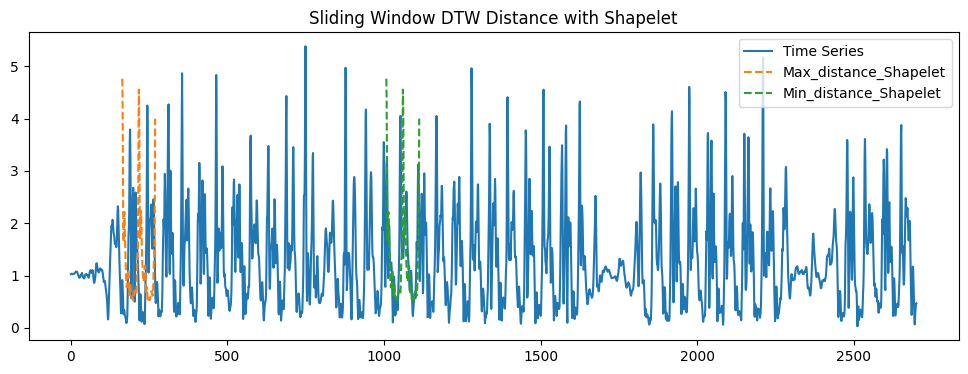

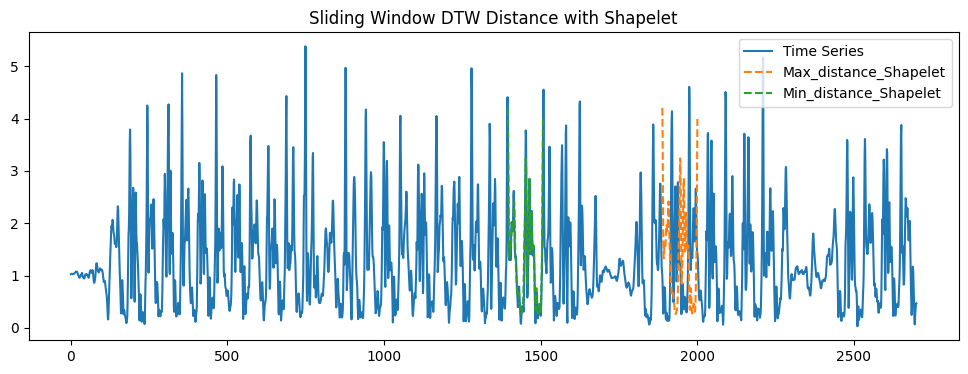

In [95]:
# window_size is shapelet length
z_bc_distances = shapelet_window_distance(z_barycenter_df, z_skip)
# skip_rs
z_rs_distances = shapelet_window_distance(pd.DataFrame(z_skip_rs), z_skip)

-------------barycenter------------


,Mean,Min,Max
0,50.957639,25.156874,96.134821


--------------skip_rs--------------


,Mean,Min,Max
0,48.676748,12.684421,95.746421


[25.15687423734477, 25.716826695023304, 25.845381305919457, 26.051721319312463, 26.193550621802665, 26.242234526456805, 26.838809593655384, 26.842939692117223, 26.8925871147987, 26.937801449796893, 27.125403321546155, 27.191106213411434, 27.60901107164683, 27.683475335658215, 27.8652761830223, 27.911857526674503, 28.11320808758157, 28.483904558150268, 28.615081551453027, 28.618699776144233, 28.7031554606178, 28.748200824007416, 28.775781317332083, 28.81101341130732, 28.965122937195606, 28.98676612882825, 29.042989214257712, 29.04392575126204, 29.056370907125814, 29.110901326912213, 29.17219801992955, 29.346141381701038, 29.373553732566958, 29.404705698623545, 29.540545334823747, 29.604579452207368, 29.605021850815458, 29.6136636531226, 29.627956986392377, 29.659388880630093, 29.90367855844909, 29.922007012280876, 29.934630890679095, 30.073380167013052, 30.08342442925035, 30.105448402734034, 30.13236082812051, 30.16352600076406, 30.25383512682313, 30.298207082180475, 30.300760669383266,

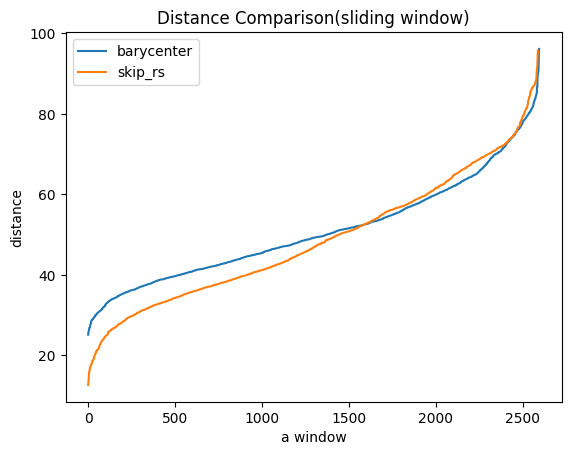

t-statistic: 5.745834816134259
p-value: 9.668948105977012e-09
There is a significant difference between the groups.


In [96]:
visual_comparison(z_bc_distances, z_rs_distances, label1='barycenter', label2='skip_rs', method='sliding window')
significance_test(z_bc_distances, z_rs_distances)

#### Weighted dtw

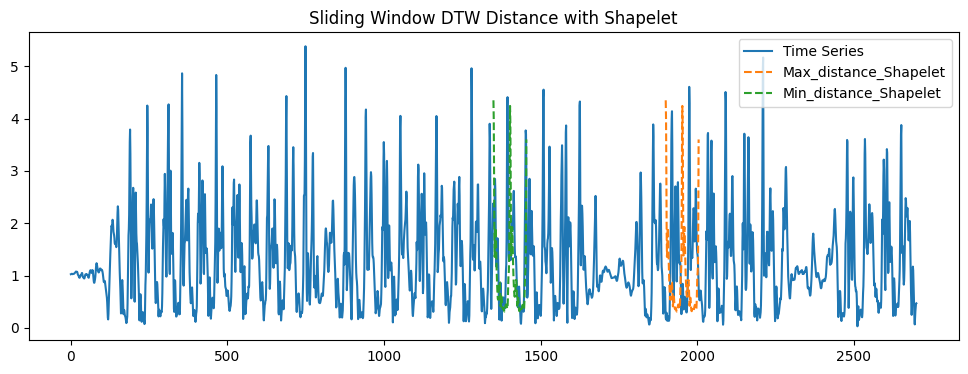

In [97]:
# window_size is shapelet length
z_wt_distances = shapelet_window_distance(z_weighted_df, z_skip)

-------------barycenter------------


,Mean,Min,Max
0,44.30883,21.340152,91.727076


--------------skip_rs--------------


,Mean,Min,Max
0,48.676748,12.684421,95.746421


[21.340151602069135, 21.53718082659744, 21.599167998770575, 21.667210656820842, 21.688560273873254, 21.91359575869297, 22.0642134360329, 22.06758272534671, 22.095280411260443, 22.119016816186086, 22.159520173863005, 22.170911025403072, 22.824847849247195, 23.07884762342829, 23.112977150449062, 23.4431577361633, 23.509325353742163, 23.549456291201594, 23.687208539806004, 23.794374679805834, 23.86721559251111, 23.91303787291078, 23.94056791783023, 23.958619076047817, 24.014725689073792, 24.028149418366347, 24.049829987772082, 24.1138920887378, 24.250122627709352, 24.296880541677822, 24.331536529776617, 24.402775759975327, 24.410186818554926, 24.411724698636498, 24.424493113518796, 24.475575557809286, 24.633808664152216, 24.657745656250068, 24.681018128682748, 24.68330309724923, 24.99120827264018, 25.056151063267297, 25.10478971197102, 25.16092436050524, 25.207524813484987, 25.237343525596895, 25.30706855157484, 25.32552187077709, 25.33640154984955, 25.362832614984104, 25.36812537701554, 

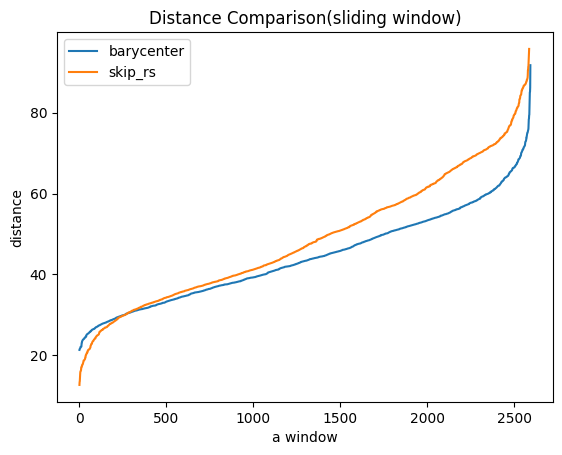

t-statistic: -11.380611756949492
p-value: 1.1723752456462403e-29
There is a significant difference between the groups.


In [98]:
visual_comparison(z_wt_distances, z_rs_distances, label1='barycenter', label2='skip_rs', method='sliding window')
significance_test(z_wt_distances, z_rs_distances)

### Candidate 2

#### Barycenter

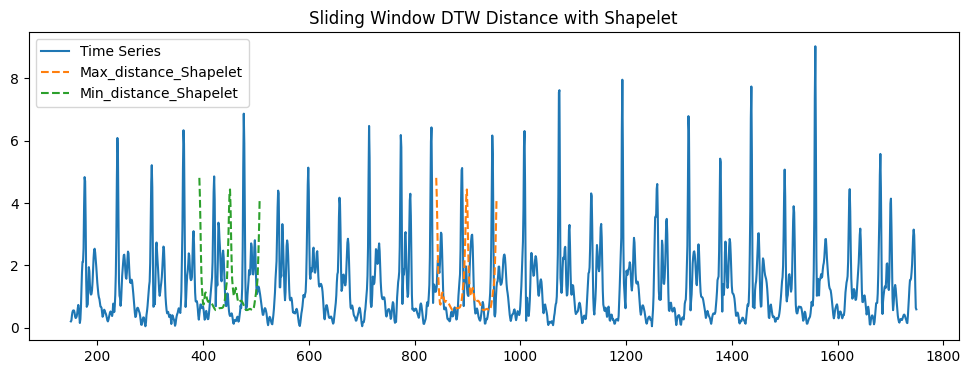

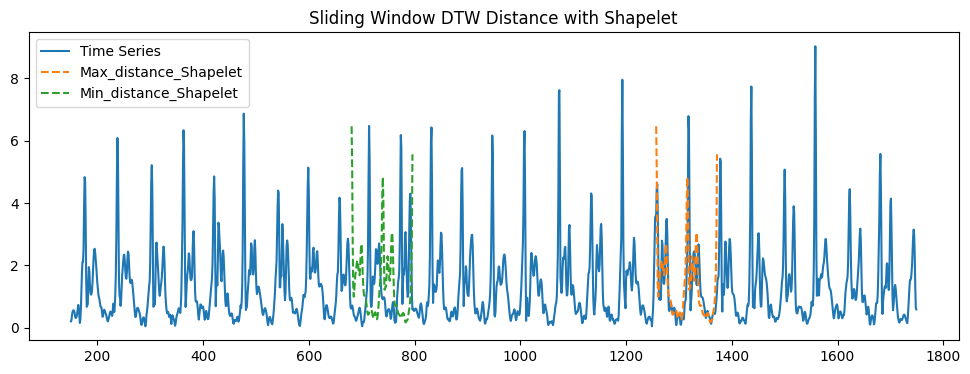

In [99]:
# window_size is shapelet length
g_bc_distances = shapelet_window_distance(g_barycenter_df, g_skip)
# skip_rs
g_rs_distances = shapelet_window_distance(pd.DataFrame(g_skip_rs), g_skip)

-------------barycenter------------


,Mean,Min,Max
0,69.727272,33.631569,104.455679


--------------skip_rs--------------


,Mean,Min,Max
0,56.640878,19.428801,104.545638


[33.63156896512307, 35.24184929394144, 35.91201002471907, 36.35637230603014, 37.35566914758948, 37.59022646626836, 37.62101215683586, 37.843804021779725, 38.16498466031382, 38.3299870860338, 38.70682528267719, 38.96758239617921, 39.204388305095335, 39.40006939134738, 39.451459941416154, 39.64756670172969, 39.78543746555185, 39.792980711995845, 39.85446822142921, 39.92975926221262, 39.968621007244046, 40.09459396683818, 40.0952979594093, 40.183393181793754, 40.36874967601632, 40.61869384151312, 40.82591028858865, 40.972766163565254, 41.21562326795844, 41.67264199962952, 41.6976441914039, 42.03470157415862, 42.22634835468409, 42.30622750255093, 42.3363114290105, 42.36349082527311, 42.44992129408507, 42.48250477627635, 42.54872565388081, 42.671598838651896, 42.686930120753445, 42.87397084887098, 42.9049931618456, 43.00772967332854, 43.15579564741576, 43.53517306502266, 43.75078025964594, 43.7703275498783, 44.42983655840382, 44.437905881864225, 44.6409951845745, 44.654844110038326, 44.7951

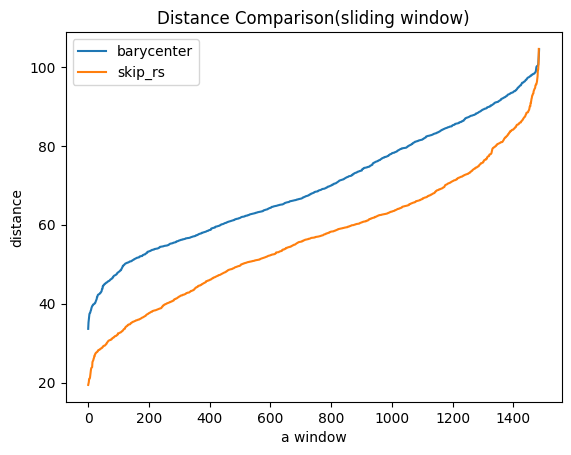

t-statistic: 22.8947496093385
p-value: 5.713352118934624e-107
There is a significant difference between the groups.


In [100]:
visual_comparison(g_bc_distances, g_rs_distances, label1='barycenter', label2='skip_rs', method='sliding window')
significance_test(g_bc_distances, g_rs_distances)

#### Weighted dtw

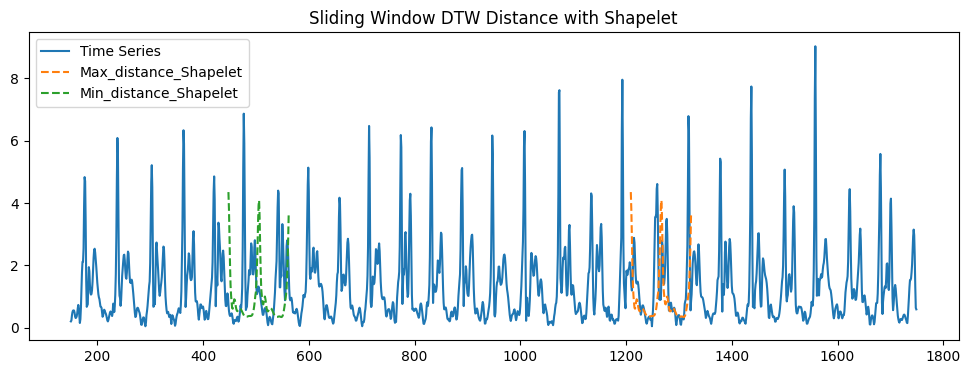

In [101]:
# window_size is shapelet length
g_wt_distances = shapelet_window_distance(g_weighted_df, g_skip)

-------------barycenter------------


,Mean,Min,Max
0,59.862229,26.000436,96.175532


--------------skip_rs--------------


,Mean,Min,Max
0,56.640878,19.428801,104.545638


[26.000436362327896, 26.236669936019098, 27.534811744678592, 27.81684775040139, 28.630109567274193, 29.325542247722588, 29.628421486407557, 30.974532399599205, 31.118305586817222, 31.128789000139676, 31.494133566301006, 31.605429768868525, 32.08379987713794, 32.10078684081217, 32.24597458863839, 32.47680216234187, 32.53407308340757, 32.67844661981436, 33.01272376645934, 33.129670377408544, 33.152560588664755, 33.27003004149993, 33.2898384172339, 33.36564597456748, 33.78221693506333, 33.80654625034858, 34.570556064611274, 34.71195767147394, 34.72690916104153, 34.83396022122543, 34.86778964658798, 34.99538470185908, 35.0132128643512, 35.02131240516677, 35.07462208878689, 35.124091012334496, 35.22276680296163, 35.50803653974502, 35.53511051591148, 35.59074000723198, 35.625341148888644, 35.8516982737388, 35.87827737813148, 36.23761967083321, 36.33228737076351, 36.63718281936049, 36.694364351683106, 36.734982146663405, 36.7593939891341, 36.84205858422268, 36.84254970646195, 36.9130142576118

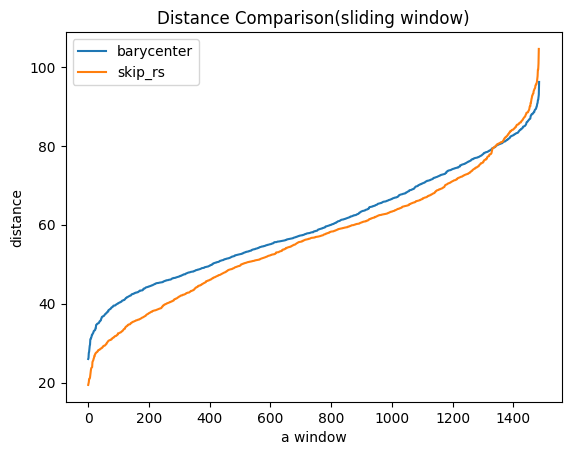

t-statistic: 5.823904666631003
p-value: 6.364573779599613e-09
There is a significant difference between the groups.


In [102]:
visual_comparison(g_wt_distances, g_rs_distances, label1='barycenter', label2='skip_rs', method='sliding window')
significance_test(g_wt_distances, g_rs_distances)

## Evaluate accuracy by cycles in time series

In [103]:
def distances_from_cycle(zqw_skip_cycles, rs_shapelet):
    distances_arr = []
    for arr in zqw_skip_cycles:
        distance, _ = fastdtw(pd.DataFrame(arr), rs_shapelet, dist=euclidean)
        distances_arr.append(distance)
    return distances_arr

### Candidate 1

#### Barycenter

In [104]:
# barycenter
z_bary_dist = distances_from_cycle(z_skip_cycles, z_barycenter_df)
# skip_rs
z_rs_dist = distances_from_cycle(z_skip_cycles, pd.DataFrame(z_skip_rs))

-------------barycenter------------


,Mean,Min,Max
0,39.44331,23.542849,63.374102


--------------skip_rs--------------


,Mean,Min,Max
0,33.027806,14.972689,63.371953


[23.542849243400077, 25.064443872725604, 25.428894897189366, 28.81565033644374, 29.197522361583335, 29.868045787284903, 30.468211889003932, 31.249212280238762, 32.27621521085207, 32.35551995989057, 32.51775160572045, 32.67596592351882, 36.237725787566596, 36.8596275731866, 39.26797764268599, 39.98447154934111, 42.27728882815595, 44.012388669205684, 44.34255679104421, 45.75782016206022, 46.49586764326509, 46.88214699426653, 47.746904841528334, 48.27012882641465, 50.85470034346148, 51.51047913226269, 51.613849051811364, 54.907680234139264, 63.37410219327155]
[14.972689082854908, 15.406352595405677, 15.881692491172677, 15.941661777193485, 17.22328037680584, 17.468086488793535, 19.31278653258192, 19.850688422979143, 21.27572403972739, 22.100018034814013, 25.815984551640696, 26.850290097280578, 28.262841320956873, 30.284557568249404, 31.519061985518018, 34.06364782128957, 34.97996764560495, 36.86256780698509, 37.21165100245912, 38.83887959012657, 40.59747084992821, 41.10218087179417, 44.436

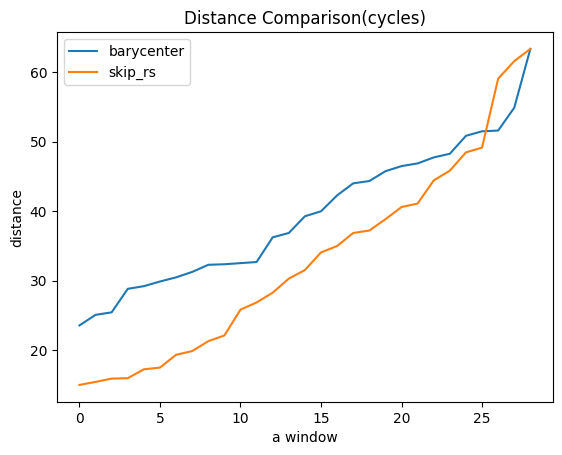

t-statistic: 1.9525289192999113
p-value: 0.05588092646394789
There is no significant difference between the groups.


In [105]:
visual_comparison(z_bary_dist, z_rs_dist, label1='barycenter', label2='skip_rs', method='cycles' )
significance_test(z_bary_dist, z_rs_dist)

#### Weighted dtw

-------------barycenter------------


,Mean,Min,Max
0,36.546558,19.04875,84.890148


--------------skip_rs--------------


,Mean,Min,Max
0,33.027806,14.972689,63.371953


[19.048750459988725, 20.931363317911572, 23.87944104203814, 25.606734395634906, 25.840606155414047, 25.925132239147956, 26.83486990252316, 27.312238406535144, 27.449011889420635, 31.31115634214093, 32.061690092886934, 34.6203260753518, 35.81271552667857, 35.92892391212, 36.30109396331721, 36.95100820175772, 37.515757281193935, 37.54054059512308, 38.85632424781792, 39.81330797784286, 39.91306277735526, 41.7491018077633, 42.35300231745776, 43.14345657552177, 43.21462694860429, 45.211428248882555, 45.592273750553595, 54.242081685923466, 84.89014820859602]
[14.972689082854908, 15.406352595405677, 15.881692491172677, 15.941661777193485, 17.22328037680584, 17.468086488793535, 19.31278653258192, 19.850688422979143, 21.27572403972739, 22.100018034814013, 25.815984551640696, 26.850290097280578, 28.262841320956873, 30.284557568249404, 31.519061985518018, 34.06364782128957, 34.97996764560495, 36.86256780698509, 37.21165100245912, 38.83887959012657, 40.59747084992821, 41.10218087179417, 44.4362928

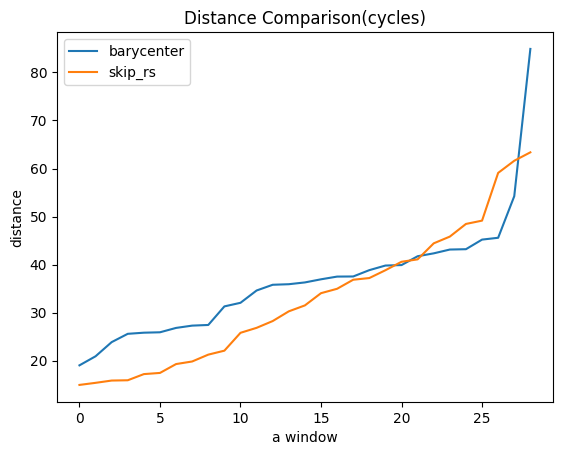

t-statistic: 0.9919616396934877
p-value: 0.32548318430386436
There is no significant difference between the groups.


In [106]:
z_weighted_dist = distances_from_cycle(z_skip_cycles, z_weighted_df)
visual_comparison(z_weighted_dist, z_rs_dist, label1='barycenter', label2='skip_rs', method='cycles' )
significance_test(z_weighted_dist, z_rs_dist)

### Candidate 2

#### Barycenter

In [107]:
# barycenter
g_bary_dist = distances_from_cycle(g_skip_cycles, g_barycenter_df)
# skip_rs
g_rs_dist = distances_from_cycle(g_skip_cycles, pd.DataFrame(g_skip_rs))

-------------barycenter------------


,Mean,Min,Max
0,50.725114,27.084183,66.0174


--------------skip_rs--------------


,Mean,Min,Max
0,42.372542,20.139492,59.80756


[27.084182800244786, 32.841044757305205, 37.451870181086754, 37.59676302892139, 41.34792810111841, 44.05010361289178, 44.95352541615626, 48.14306728547142, 50.86988935113042, 53.26083660451924, 54.10850776980459, 54.85382303018592, 55.190293504133216, 55.572548955583656, 58.147181875608425, 61.44751572474283, 62.077908719447485, 63.57933214428034, 65.90856362998797, 66.01739999497799]
[20.139492092635276, 21.032591983036117, 21.580635899361937, 22.942089200086947, 26.520539959300667, 35.35438608191016, 36.48950749711537, 39.836520262427705, 41.55110061212906, 42.13373329170397, 44.25010109922335, 48.71599073266802, 51.35073354004173, 52.31585363762352, 53.77179168016427, 56.392210353312784, 56.54644842917957, 57.03418804165125, 59.685368047279404, 59.80756002977078]


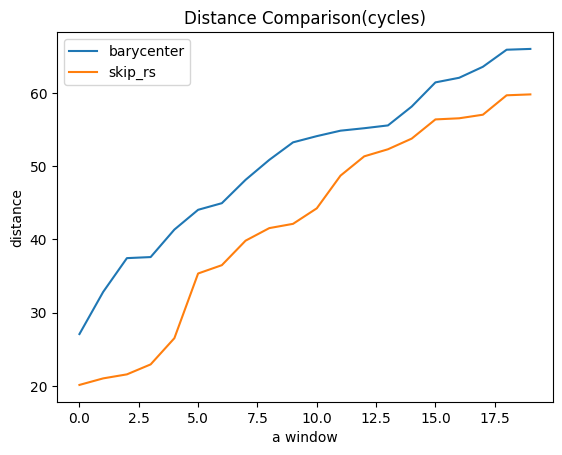

t-statistic: 2.0885120967792457
p-value: 0.04350400440268202
There is a significant difference between the groups.


In [108]:
visual_comparison(g_bary_dist, g_rs_dist, label1='barycenter', label2='skip_rs', method='cycles' )
significance_test(g_bary_dist, g_rs_dist)

#### Weighted dtw

-------------barycenter------------


,Mean,Min,Max
0,47.576944,29.023864,56.982712


--------------skip_rs--------------


,Mean,Min,Max
0,42.372542,20.139492,59.80756


[29.023864433438458, 41.2967590064009, 42.01574025310089, 42.20118892695015, 42.83457934018084, 44.09478214723438, 45.73844423794924, 46.49867099250934, 46.55252891352116, 47.813160412369875, 49.477287849194134, 50.653729500684385, 50.760888222816945, 50.81700643348306, 51.025408198001884, 51.32931335039909, 51.745619591367024, 54.154252652996334, 56.522947445930136, 56.98271170426243]
[20.139492092635276, 21.032591983036117, 21.580635899361937, 22.942089200086947, 26.520539959300667, 35.35438608191016, 36.48950749711537, 39.836520262427705, 41.55110061212906, 42.13373329170397, 44.25010109922335, 48.71599073266802, 51.35073354004173, 52.31585363762352, 53.77179168016427, 56.392210353312784, 56.54644842917957, 57.03418804165125, 59.685368047279404, 59.80756002977078]


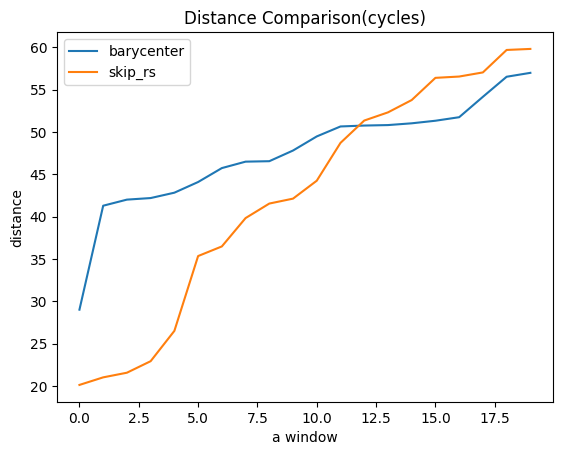

t-statistic: 1.5219067895355414
p-value: 0.13631129098338826
There is no significant difference between the groups.


In [109]:
g_weighted_dist = distances_from_cycle(g_skip_cycles, g_weighted_df)
visual_comparison(g_weighted_dist, g_rs_dist, label1='barycenter', label2='skip_rs', method='cycles' )
significance_test(g_weighted_dist, g_rs_dist)

## Evaluate by random pick

In [110]:
def random_compare(shapelet, time_series):
    window_size = len(shapelet)
    data_point = len(time_series)
    distances = []
    count_pick = 1000
    while (count_pick > 0):
        random_int = random.randint(0, data_point - window_size) # avoid out of time series range
        window = time_series[random_int : random_int + window_size]
        window_df = pd.DataFrame(window)
        # Calculate DTW distance between the window and the shapelet
        distance, _ = fastdtw(window_df, pd.DataFrame(shapelet), dist=euclidean)
        distances.append(distance)
        count_pick -= 1
    return distances

### Candidate 1

-------------barycenter------------


,Mean,Min,Max
0,51.236222,26.83881,96.134821


--------------skip_rs--------------


,Mean,Min,Max
0,47.452593,14.787483,90.525808


[26.838809593655384, 27.60901107164683, 27.683475335658215, 27.8652761830223, 27.8652761830223, 27.911857526674503, 28.483904558150268, 28.483904558150268, 28.618699776144233, 28.748200824007416, 28.81101341130732, 28.965122937195606, 29.056370907125814, 29.110901326912213, 29.404705698623545, 29.404705698623545, 29.6136636531226, 29.90367855844909, 30.073380167013052, 30.073380167013052, 30.300760669383266, 30.72231294873776, 30.749545194284213, 30.854627803840728, 30.95947551604134, 30.95947551604134, 31.026793914461237, 31.295722037261807, 31.328336361328684, 31.869777195381637, 31.869777195381637, 32.02335932462299, 32.09354248109706, 32.09354248109706, 32.09354248109706, 32.16963627157867, 32.36894730238801, 32.64394918125183, 32.71428071736304, 33.00671417958422, 33.26628741005127, 33.314198912921604, 33.382997695116345, 33.489411026574736, 33.50044849764284, 33.711561980918695, 33.839169833615536, 33.88946745436565, 33.98271109258329, 33.998368041012284, 33.998368041012284, 34.0

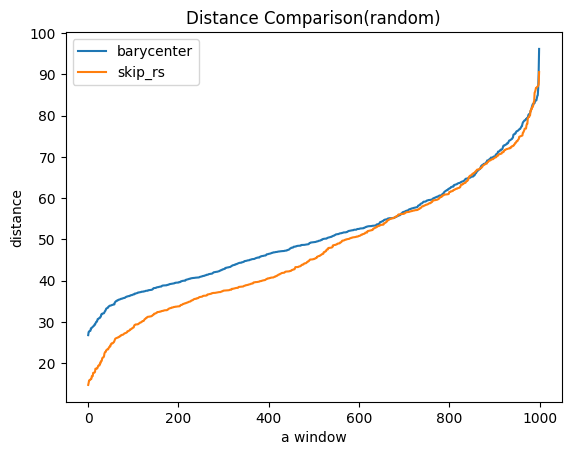

t-statistic: 5.9499675705738575
p-value: 3.1588837665246828e-09
There is a significant difference between the groups.


In [111]:
z_bc_random_dist = random_compare(z_barycenter_df, z_skip)
z_rs_random_dist = random_compare(z_skip_rs, z_skip)
visual_comparison(z_bc_random_dist, z_rs_random_dist, label1='barycenter', label2='skip_rs', method='random' )
significance_test(z_bc_random_dist, z_rs_random_dist)

### Candidate 2

-------------barycenter------------


,Mean,Min,Max
0,69.693881,33.631569,104.455679


--------------skip_rs--------------


,Mean,Min,Max
0,56.619251,19.428801,104.545638


[33.63156896512307, 35.24184929394144, 37.35566914758948, 37.62101215683586, 37.62101215683586, 38.16498466031382, 38.3299870860338, 38.3299870860338, 39.204388305095335, 39.40006939134738, 39.451459941416154, 39.451459941416154, 39.64756670172969, 39.792980711995845, 39.85446822142921, 39.968621007244046, 40.183393181793754, 40.36874967601632, 40.82591028858865, 41.67264199962952, 41.6976441914039, 41.6976441914039, 42.22634835468409, 42.30622750255093, 42.30622750255093, 42.3363114290105, 42.3363114290105, 42.54872565388081, 42.671598838651896, 42.686930120753445, 42.686930120753445, 42.87397084887098, 42.9049931618456, 42.9049931618456, 43.7703275498783, 43.7703275498783, 44.42983655840382, 44.437905881864225, 44.437905881864225, 44.6409951845745, 44.654844110038326, 44.91952511560483, 45.1188579205885, 45.17001664074766, 45.38044502489023, 45.484923426528844, 45.55627743900576, 45.73072554819944, 45.73974782795932, 45.73974782795932, 45.80456618464669, 45.80456618464669, 45.8045661

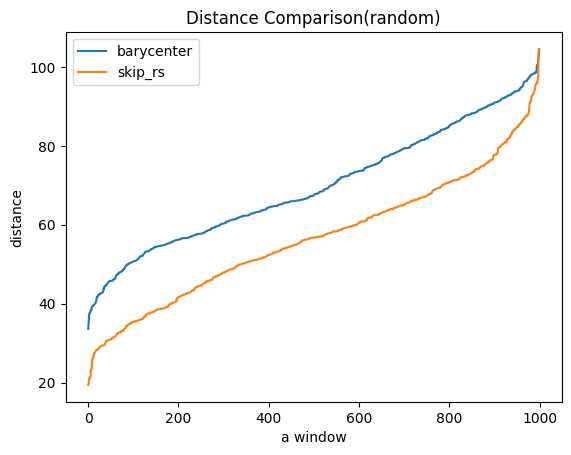

t-statistic: 18.788224599358568
p-value: 1.1915233272244292e-72
There is a significant difference between the groups.


In [112]:
g_bc_random_dist = random_compare(g_barycenter_df, g_skip)
g_rs_random_dist = random_compare(g_skip_rs, g_skip)
visual_comparison(g_bc_random_dist, g_rs_random_dist, label1='barycenter', label2='skip_rs', method='random' )
significance_test(g_bc_random_dist, g_rs_random_dist)